In [1]:
from PIL import Image

# Paths to your mask and ultrasound images
mask_image_path = r'C:\Users\Param Madan\Desktop\aligned_dataset\002\masks\002_frame_000002.png'
ultrasound_image_path = r'C:\Users\Param Madan\Desktop\aligned_dataset\002\JPEGImages\002_frame_000002.jpg'

# Open the images
mask_image = Image.open(mask_image_path)
ultrasound_image = Image.open(ultrasound_image_path)

# Get the sizes of both images
mask_size = mask_image.size
ultrasound_size = ultrasound_image.size

# Check if the sizes match
if mask_size == ultrasound_size:
    print(f"Sizes match! Both images are {mask_size}")
else:
    print(f"Sizes do not match! Mask size: {mask_size}, Ultrasound image size: {ultrasound_size}")



Sizes match! Both images are (1040, 768)


In [2]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, concatenate, Input

# Load VGG16, exclude the fully connected layers, and keep only the convolutional base
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in VGG16 to avoid training them
for layer in vgg16.layers:
    layer.trainable = False

# Encoder part
inputs = Input(shape=(224, 224, 3))
c1 = vgg16.get_layer('block1_conv2').output  # Use outputs from a specific layer as an encoder
c2 = vgg16.get_layer('block2_conv2').output
# You can continue extracting features like this or create new layers on top of this

# Decoder part (example)
u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c2)
u1 = concatenate([u1, c1], axis=3)
u1 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

# Add more decoder layers as needed...

# Final segmentation output
outputs = Conv2D(1, (1, 1), activation='sigmoid')(u1)

# Define the complete model
model = Model(inputs=[vgg16.input], outputs=[outputs])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [35]:
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras import regularizers

# Define the image processing function
def process_image(image_path):
    # Load the image (adjust as_gray=True for grayscale images)
    img = imread(image_path, as_gray=True)  # Replace as_gray=False if using RGB images
    # Resize the image to the desired shape (IMG_HEIGHT, IMG_WIDTH)
    img_resized = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    # Add channel dimension (for grayscale, we add a single channel)
    img_resized = np.expand_dims(img_resized, axis=-1)
    return img_resized

import os  # Add this line to import the os module
import numpy as np
from tqdm import tqdm
from skimage.io import imread
import albumentations as A
import tensorflow as tf


# Paths for the training and validation datasets
TRAIN_PATH = r'C:\Users\Param Madan\Desktop\aligned_dataset\split_dataset\train\JPEGImages\\'
MASK_TRAIN_PATH = r'C:\Users\Param Madan\Desktop\aligned_dataset\split_dataset\train\masks\\'
VALIDATION_PATH = r'C:\Users\Param Madan\Desktop\aligned_dataset\split_dataset\val\JPEGImages\\'
MASK_VALIDATION_PATH = r'C:\Users\Param Madan\Desktop\aligned_dataset\split_dataset\val\masks\\'

IMG_HEIGHT = 224  # Example height, replace with the actual height of your images
IMG_WIDTH = 224   # Example width, replace with the actual width of your images
IMG_CHANNELS = 1  # Assuming grayscale images (for ultrasound), if RGB, set to 3


# Get image filenames (IDs)
train_ids = next(os.walk(TRAIN_PATH))[2]  # Get filenames for training images
val_ids = next(os.walk(VALIDATION_PATH))[2]

# Get image filenames (IDs)
train_ids = next(os.walk(TRAIN_PATH))[2]  # Get filenames for training images
val_ids = next(os.walk(VALIDATION_PATH))[2]

# Initialize arrays for storing images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)

X_val = np.zeros((len(val_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_val = np.zeros((len(val_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)

# Loading and resizing training images and masks
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    X_train[n] = process_image(TRAIN_PATH + id_)
    mask_id = id_.replace('.jpg', '.png')  # Adjust if masks are in .png format
    Y_train[n] = process_image(MASK_TRAIN_PATH + mask_id)

# Repeat for validation data
for n, id_ in tqdm(enumerate(val_ids), total=len(val_ids)):
    X_val[n] = process_image(VALIDATION_PATH + id_)
    mask_id = id_.replace('.jpg', '.png')  # Adjust if masks are in .png format
    Y_val[n] = process_image(MASK_VALIDATION_PATH + mask_id)

# Check the shapes to ensure they are correct
print("X_train shape:", X_train.shape)  # Expected shape: (1461, 224, 224, 1)
print("Y_train shape:", Y_train.shape)  # Expected shape: (1461, 224, 224, 1)
print("X_val shape:", X_val.shape)      # Expected shape: (321, 224, 224, 1)
print("Y_val shape:", Y_val.shape)      # Expected shape: (321, 224, 224, 1)

# Define the U-Net model (as per your current model structure)
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)  # Normalize the input

from tensorflow.keras import regularizers

# Contracting path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(s)
c1 = tf.keras.layers.Dropout(0.2)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(p1)
c2 = tf.keras.layers.Dropout(0.2)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', 
                            kernel_regularizer=regularizers.l2(0.01))(c9)

# Final output layer
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)


# Define the model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


100%|██████████| 321/321 [00:15<00:00, 20.70it/s]


X_train shape: (1461, 224, 224, 1)
Y_train shape: (1461, 224, 224, 1)
X_val shape: (321, 224, 224, 1)
Y_val shape: (321, 224, 224, 1)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 224, 224,  │        160 │ lambda_4[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 224, 224,  │          0 │ conv2d_78[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 224, 224,  │      2,320 │ dropout_36[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 112, 112,  │          0 │ conv2d_79[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 112, 112,  │      4,640 │ max_pooling2d_16… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 112, 112,  │          0 │ conv2d_80[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 112, 112,  │      9,248 │ dropout_37[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 56, 56,    │          0 │ conv2d_81[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 56, 56,    │     18,496 │ max_pooling2d_17… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 56, 56,    │          0 │ conv2d_82[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 56, 56,    │     36,928 │ dropout_38[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 28, 28,    │          0 │ conv2d_83[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 28, 28,    │     73,856 │ max_pooling2d_18… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 28, 28,    │          0 │ conv2d_84[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_85 (Conv2D)  │ (None, 28, 28,    │    147,584 │ dropout_39[0][0]

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

46/46 ━━━━━━━━━━━━━━━━━━━━ 26s 575ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step


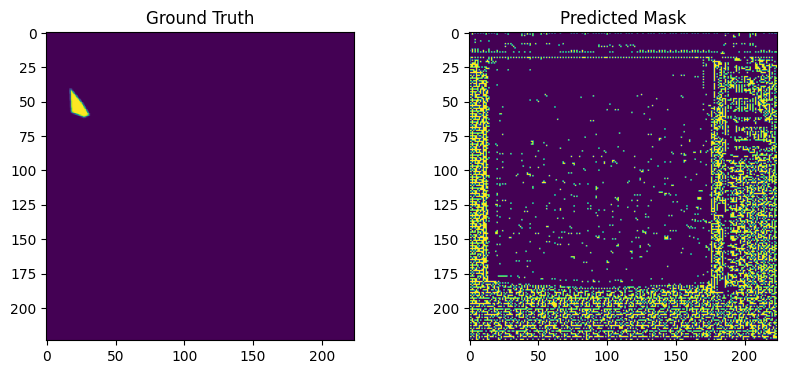

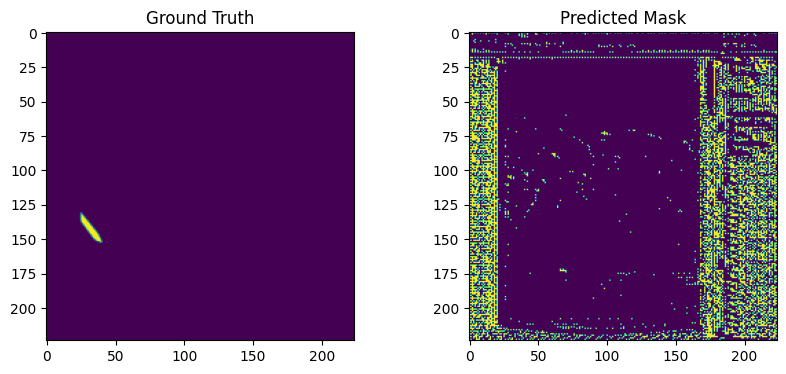

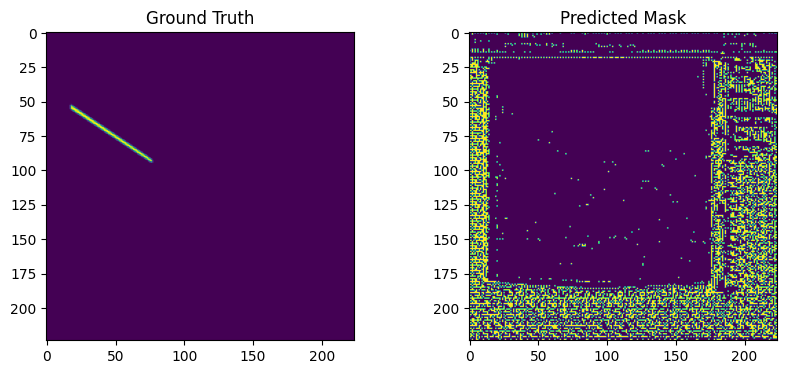

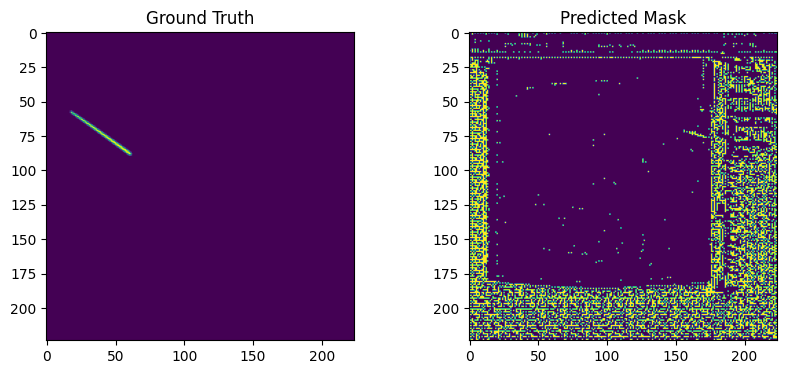

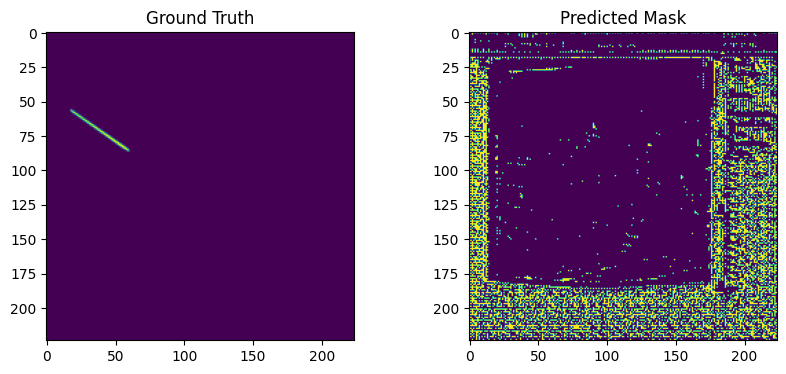

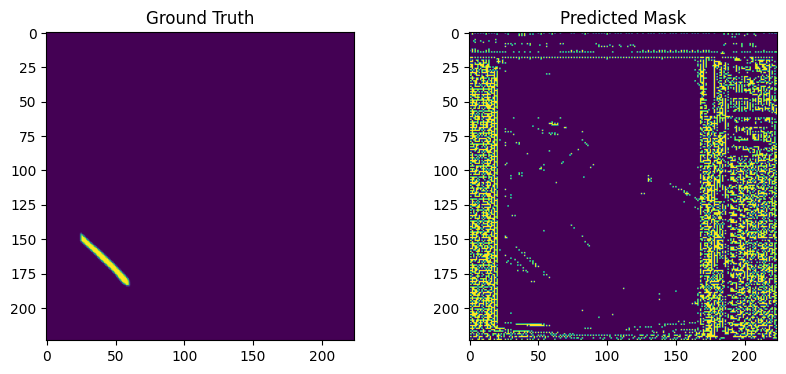

In [37]:
#model is ovverfiting using 10 oercent droopout and L2 regularixzation
import random
import matplotlib.pyplot as plt

# Predict on the training and validation sets
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)

# Apply threshold to get binary masks
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Sanity check on random training samples
for _ in range(3):  # Show a few samples
    i = random.randint(0, len(preds_train_t))  # Random index
    
    # Show the original mask and the predicted mask side by side
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(Y_train[i]))  # Ground truth mask
    plt.title("Ground Truth")
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(preds_train_t[i]))  # Predicted mask
    plt.title("Predicted Mask")
    
    plt.show()

# Repeat for validation samples
for _ in range(3):  # Show a few samples
    i = random.randint(0, len(preds_val_t))  # Random index
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(Y_val[i]))  # Ground truth mask
    plt.title("Ground Truth")
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(preds_val_t[i]))  # Predicted mask
    plt.title("Predicted Mask")
    
    plt.show()


In [ ]:
#model is overfitting ,high accuracy 0.99 so we will regularize

In [ ]:
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=5,  # Reduce initially to check training
                    batch_size=4,  # Reduce batch size to manage memory
                    verbose=1)  # Enable verbosity for progress tracking
